In [19]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os,sys
from glob import glob
from scipy.optimize import fmin
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy import interpolate
import time
from multiprocessing import Process, Array, Lock

In [20]:
def is_in_notebook():
    import sys
    return 'ipykernel' in sys.modules

def clear_output():
    """
    clear output for both jupyter notebook and the console
    """
    import os
    os.system('cls' if os.name == 'nt' else 'clear')
    if is_in_notebook():
        from IPython.display import clear_output as clear
        clear()
        
print('bbb')
clear_output()

In [4]:
def find_all_byname():
    binary_list = np.genfromtxt("binary.txt",dtype=str)
    binary_dir = []
    for b in binary_list:
        search = '/Users/laote/sdsu/Research/binary/curve_bin/Curve_binary_320000sort/%s_*_LC.txt'%b
        look_dir = glob(search)
        for i in range(len(look_dir)):
            binary_dir.append(look_dir[i])
    return binary_dir

In [5]:
def see_period(datadir):
    data = np.genfromtxt(datadir,names="time,flux,et,ef")
    use = (data['ef'] == 0)

    time_diff = data['time'][use][1:] - data['time'][use][:-1]
    error_point = np.argmax(time_diff)
    
    Time = np.append(data['time'][use][5:error_point-5],data['time'][use][error_point+5:-4])
    flux = np.append(data['flux'][use][5:error_point-5],data['flux'][use][error_point+5:-4])

    med = np.median(flux) 
    std = np.std(flux)
    
    plt.figure(figsize=(10,5))
    plt.plot(Time,flux,'c')
    plt.plot(Time,flux,'r.')
#     plt.xlim(3438+3,3442+3)
    plt.show()

In [6]:
def light_curve(lc_dir,look=False):
    data = np.genfromtxt(lc_dir,names="time,flux,et,ef")
    good = (data['ef'] == 0)
    time_diff = data['time'][good][1:] - data['time'][good][:-1]
    
    if (np.max(time_diff) < 10):
        error_point = np.argmax(time_diff)

        time = np.append(data['time'][good][15:error_point-35],data['time'][good][error_point+35:-15])
        flux = np.append(data['flux'][good][15:error_point-35],data['flux'][good][error_point+35:-15])
        et = np.append(data['et'][good][15:error_point-35],data['et'][good][error_point+35:-15])
        
        min_flux = np.min(np.append(flux[int(len(flux)*0.05):int(len(flux)*0.4)],\
                                    flux[int(len(flux)*0.6):-int(len(flux)*0.05)]))
        

        norm_flux = (flux - np.median(flux))/(np.median(flux) - min_flux)
        norm_et = et / np.abs(np.median(flux) - min_flux)

        if look == True:
            plt.figure(figsize=(10,5))
            plt.plot(time,norm_flux,'c')
            plt.xlabel('time');plt.ylabel('flux')
            plt.show()
        else:
            None
        
        w = (norm_flux < 0.15) & (norm_flux > -1.5)
        return time[w],norm_flux[w],norm_et[w]

    else:
        return "bad_data","bad_data","bad_data"


def mulit_light_curve(lc_dir,look=False):
    time = []; flux = []; et = []
    size = 0
    for i in range(10):
        test_dir = lc_dir[:-9] + "0%s" %i + "_LC.txt"
        if os.path.exists(test_dir) == True:
            t,f,e = light_curve(test_dir)
            if t == 'bad_data':
                None
            else:
                time.extend(t)
                flux.extend(f)
                et.extend(e)
                size += 1
        else:
            None

    for i in range(10):
        test_dir = lc_dir[:-9] + "1%s" %i + "_LC.txt"
        if os.path.exists(test_dir) == True:
            t,f,e = light_curve(test_dir)
            if t == 'bad_data':
                None
            else:
                time.extend(t)
                flux.extend(f)
                et.extend(e)
                size += 1
        else:
            None
            
    if size > 2:
        if look == True:
            plt.figure(figsize=(5*size,5))
            plt.plot(time,flux,'c')
            plt.plot(time,flux,'r.')
            plt.xlabel('time');plt.ylabel('flux')
            plt.grid()
            plt.show()
        else:
            None
    else:
        None

    return time, flux, et

In [7]:
def fit_peak(time,flux,et,h, display=False):
    time = np.array(time)
    flux = np.array(flux)
    et = np.array(et)
    
    peaks = find_peaks(-flux, height=-h)

    peaks_pos = peaks[0]
    height = -peaks[1]['peak_heights']
    


    fittime = []
    fitecc = []
    
    need_del = []
    for i in range(len(time[peaks_pos])):
        if ((peaks_pos + 5)[i] > len(time)) or ((peaks_pos - 5)[i] < 0) :
            need_del.append(i)
            
    peaks_pos = np.delete(peaks_pos, need_del)
    height = np.delete(height, need_del)
            
#     for i in range(len(time[peaks_pos])):
#         fitx = [];fity = [];fitw =[]
#         for j in range(-3,4,1):
#             fitx.append(time[peaks_pos+j][i])
#             fity.append(flux[peaks_pos+j][i])
#             fitw.append(et[peaks_pos+j][i])
#         z = np.polyfit(fitx,fity,2,w=fitw,full=True,cov=True)
#         coef = z[0]
#         ecc = z[3]
    
#         minimum = -coef[1]/(2*coef[0])
#         ecc_min = np.sqrt( ecc[1]**2 * (-1/(2*coef[0]))**2 + ecc[0]**2 * (coef[1]/(2*coef[0]**2))**2 )
#         fittime.append(minimum)
#         fitecc.append(ecc_min)
    
    fittime = time[peaks_pos]
    fitecc = peaks_pos
    
    if display == True:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(time,flux,'co-')
        plt.plot(fittime,height,'rx')
        plt.grid()
        plt.xlim(time[0],time[1000])
        
        plt.subplot(122)
        plt.plot(time,flux,'co-')
        plt.plot(fittime,height,'rx')
        plt.xlim(fittime[0]-0.5,fittime[2]+2)
        plt.grid()
        plt.show()

    return np.array(fittime), np.array(fitecc)


In [8]:
def Phase_cycle(t,P,T_0):
    T_diff = np.array(t) - T_0
    I = np.floor(T_diff/P)
    phi = (T_diff/P) - I
    return phi, I #phase and cycle



def chisq_test(half_period,ecl_time,T0,ecl_time_ecc,look=False):
    ppp = np.linspace(half_period-2,half_period+2,40)
    chisq = []
    for pp in ppp:
        phi, I = Phase_cycle(ecl_time,pp,T0)
        chisq.append(np.sum((ecl_time-(I*pp+T0))**2/1**2))
#         chisq.append(np.sum((ecl_time-I*pp-T0)**2/1**2))
#         chisq.append(np.sum(np.abs(phi)))
#         plot(I,ecl_time)

    real_p = ppp[np.argmin(chisq)]
    min_chisq = np.min(chisq)
    
    if look == True:
        plt.figure(figsize = (7,5))
        plt.title('min_chisq = %.4f' %min_chisq)
        plt.plot(ppp,chisq,'c')
        plt.show()
    
    phi, I2 = Phase_cycle(ecl_time,real_p,T0)
    sigy = np.sqrt(1/(len(ecl_time)-2)* np.sum((ecl_time-I2*real_p-T0)**2))
    Delta = len(ecl_time)*np.sum(ecl_time**2) - (np.sum(ecl_time))**2
    ecc_period = sigy * np.sqrt(len(ecl_time)/Delta)
    
    return real_p, ecc_period



def hist_test(period,ecl_time,T0,ecl_time_ecc,look=False):
    bin_num = 50
    limit = 0.2*period
    ppp = np.linspace(period-limit,period+limit,3000)
    hist_weight = []
    for pp in ppp:
        phi, I = Phase_cycle(ecl_time,pp,T0)
        hist_info = np.histogram(phi,bins=bin_num)[0]
        hist_weight.append(np.max(hist_info) - len(hist_info.nonzero()))
        

    real_p = ppp[np.argmax(hist_weight)]
    
    if look == True:
        plt.figure(figsize = (10,5))
        plt.subplot(121)
        plt.title('period = %.4f' %real_p)
        plt.plot(ppp,hist_weight,'c')
        
        phi, I = Phase_cycle(ecl_time,real_p,T0)
        plt.subplot(122)
        plt.hist(phi,bins=bin_num)
        plt.show()
    
    phi, I2 = Phase_cycle(ecl_time,real_p,T0)
    sigy = np.sqrt(1/(len(ecl_time)-2)* np.sum((ecl_time-I2*real_p-T0)**2))
    Delta = len(ecl_time)*np.sum(ecl_time**2) - (np.sum(ecl_time))**2
    ecc_period = sigy * np.sqrt(len(ecl_time)/Delta)
    
    phase = np.histogram(phi,bins=bin_num)[1][np.argmax(np.histogram(phi,bins=bin_num)[0])] + 0.01
    
    return real_p, ecc_period, ecl_time[1]

In [31]:
def Phase_cycle(t,P,T_0):
    T_diff = np.array(t) - T_0
    I = np.floor(T_diff/P)
    phi = (T_diff/P) - I
    return phi, I #phase and cycle


def sing_dc_func(guess_P,time,norm_flux,norm_et,look=False):
    phi, I = Phase_cycle(time, guess_P, time[0])
    phase_flux = np.stack((phi,norm_flux),axis=-1)
    phase_flux = np.array(sorted(phase_flux,key=lambda x:x[0]))
    phase = phase_flux[:,0]
    flux = phase_flux[:,1]
    phase_1 = [];flux_1 = []
    for i in range(100):
        w = (phase > 1/i) & (phase < 1/i)
        phase_1.append() 

    if look == True:
        plt.figure(figsize=(15,5))
        plt.plot(phase,flux,'c-')
        plt.plot(phase,flux,'r.')
        plt.xlabel('phase');plt.ylabel('flux')
        plt.show()        
    
    S = np.fabs(flux[-1] - flux[0]) + np.sum(np.fabs(flux[1:] - flux[:-1]))
    return S/47.-2.,phase,flux

In [10]:
def find_star_data(name,basedir):
    binary_dir = glob('%s/%s_*_LC.txt'%(basedir,name))
    return binary_dir

def ask_linecut(initial):
    cutline = initial
    try_num = 0
    while (cutline > 1) | (cutline < 0):
        cutline = input('0.4 cut line for the peak (from 0 to 1, if bad input "n"): ')
        if cutline == 'n':
            return 'data unable to use'
        if cutline == '':
            cutline = 0.4
        cutline = np.float(cutline)
        try_num += 1
        if try_num > 3:
            return 'input error'

    return cutline

def histmod_period(name,basedir):
    onedata = find_star_data(name,basedir)[0]
    time, flux, et = mulit_light_curve(onedata,look=True)
    
    cutline = ask_linecut(5)
    if isinstance(cutline, str):
#         return cutline
        return 0, 0, 0, 0
    else:
        None
        
    ecl_time, ecl_time_ecc = fit_peak(time,flux,et,-cutline,display=True)
    
    repick = input('want to repick cutline? (y or n)')
    if repick == 'y':
        cutline = ask_linecut(5)
        if isinstance(cutline, str):
            return cutline
        else:
            None
    else:
        None
        

    guass_period = (ecl_time[2]-ecl_time[0])
    period_ok = input('period %.4f in plot look good? (y or n): '%guass_period)
    
    if period_ok != 'n':
        print('Guass period is %.4f' %guass_period)
    else:
        guass_period = input('Give a guass period: ')
        guass_period = np.float(guass_period)


    T0 = ecl_time[0]
    period, eperiod, second_phase = hist_test(guass_period,ecl_time,T0,ecl_time_ecc,look=True)
    S715, phase715,flux715 = sing_dc_func(period,time,flux,et,look=True)
    
    folding_ok = input('period %.4f in folding need double or half or give or large eperiod? (d or h or g or l): '%period)
    
    if folding_ok == 'd':
        period = 2*period
    if folding_ok == 'h':
        period = 0.5*period
    if folding_ok == 'l':
        eperiod = 999
    if folding_ok == 'g':
        period = input('Give a guass period: ')
        period = np.float(period)
    else:
        None

    return period, eperiod, T0, second_phase

In [11]:
def run_hist_prog(name_list,basedir,startp=0,endp=1):
    if os.path.exists('period_v2.npy'):
        period_v2 = np.load('period_v2.npy')
        print("Success loading old file.")
    else:
        period_v2 = []
    period_v2 = np.array(period_v2)


    for bn in name_list[startp:endp]:
        if len(period_v2) == 0: #check empty
            None
        else:
            if bn in period_v2[:,0]: #check whether already do
                continue
            else:
                None

        param = histmod_period(bn,basedir)
        

        if isinstance(param, str):
            clear_output()
            print(param)
            continue
        else:
            period, eperiod, T0, second_phase = param
            test = np.array([[bn, period, eperiod, T0, second_phase]])

            print(test)
            test_qun = input('is that period able to record? (y or n)')
            clear_output()

            if test_qun == '':
                if len(period_v2) != 0: #check empty
                    if bn in period_v2[:,0]: #delete old data
                        row_num = np.argwhere(period_v2[:,0] == bn)[0][0]
                        period_v2 = np.delete(period_v2, row_num, 0)
                    else:
                        None

                    period_v2 = np.vstack((test,period_v2))
                    np.save('period_v2',period_v2)
                else:
                    period_v2 = test
                    np.save('period_v2',period_v2)
            else:
                None

In [12]:
basedir = '/Users/laote/sdsu/Research/binary/curve_bin/1600K_Curve_binary'


binary_name_ori = glob(basedir+'/*.txt')
binary_name = []
for bbb in binary_name_ori:
    if bbb[-28:-14] not in binary_name:
        binary_name.append(bbb[-28:-14])

In [13]:
len(binary_name)

1032

In [136]:
run_hist_prog(binary_name,basedir,startp=0,endp=606)

In [137]:
len(np.load('period_v2.npy'))


606

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


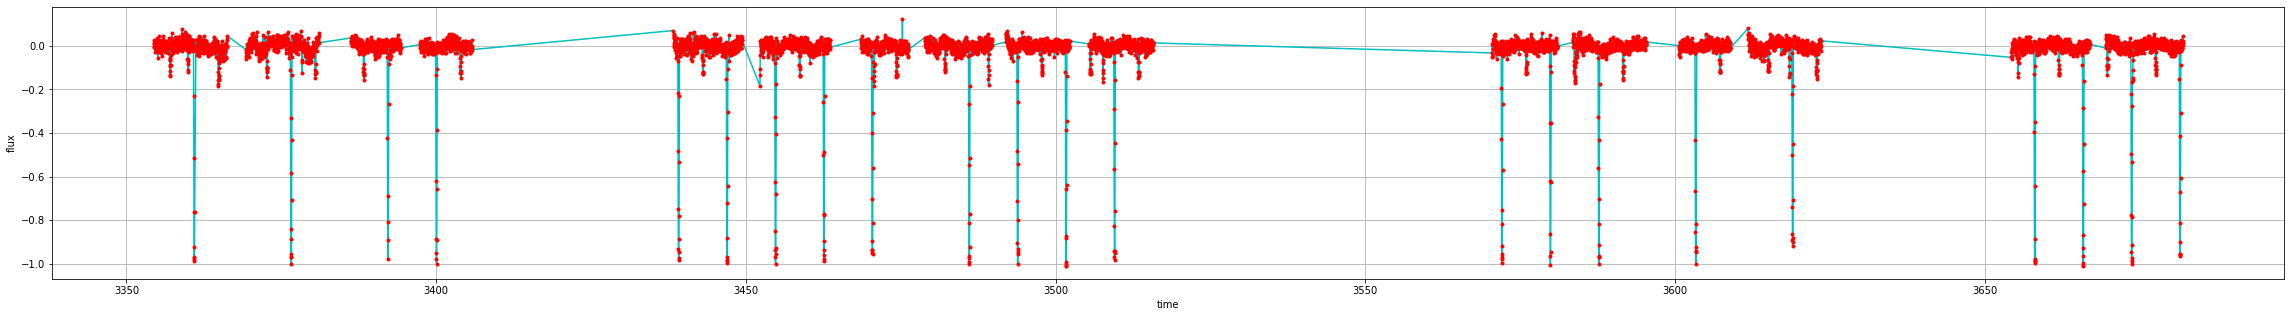

0.4 cut line for the peak (from 0 to 1, if bad input "n"): 


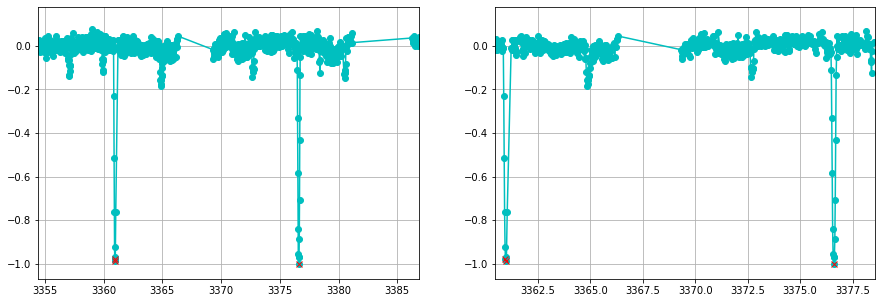

want to repick cutline? (y or n)
period 15.6457 in plot look good? (y or n): 
Guass period is 15.6457


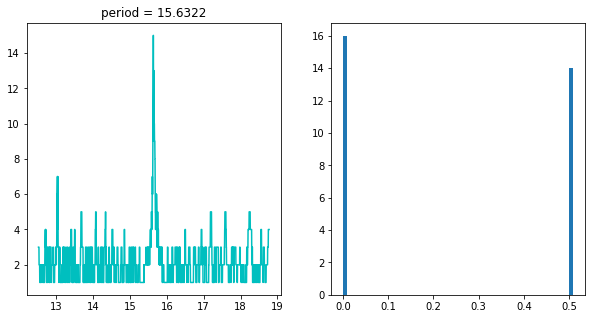

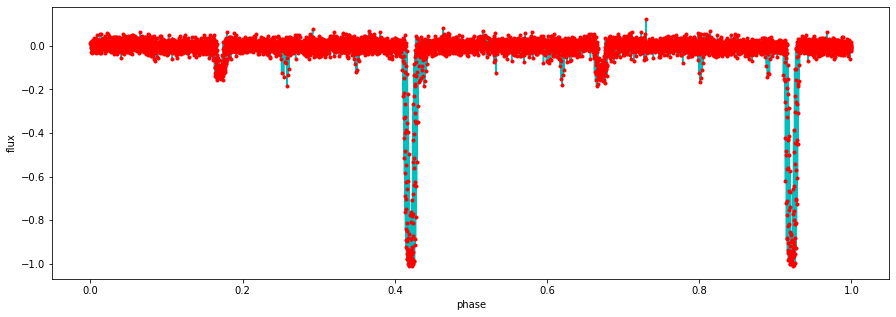

KeyboardInterrupt: 

In [21]:
run_hist_prog(['tic00041088200'],basedir)

In [14]:
#tic00306828113 lots of points in eclipse

#tic00055746372 long time eclipse
#tic00179371765 long time eclipse
#tic00150513899 pulsing star
#tic00306828113 strange lc
#tic00307367221 pulsing star
#tic00150322574 clear 17day eccertric binary. second eclipse 0.35
#tic00149351413 long orbit distance binary 6day period
#tic00306900155 possible have a third body

#tic00308843961 long time eclipse, Algol, roche lobe 
#tic00307024753 small noise high ecc second eclipse 0.70
#tic00293347945 long time eclipse
#tic00303087387 small time, Algol, roche lobe 
#tic00141479140 long time eclipse, period around 20 days
#tic00038519061 high ecc second eclipse 0.80
#tic00308083842 (22day period) high possible to have third body
#tic00302599843 clear curve second eclipse 0.30
#tic00303090810 long time eclipse long period 
#tic00303442568 clear cuve possible third body
#tic00302995864 Algol, roche lobe

In [138]:
a = np.load('period_v2.npy')
f = open('1600K_period_v2.txt','w')
f.write('tic_name         period   e_period  first_eclipse\n')
for i in range(len(a)):
    f.write('%s  %8.4f  %8.4f  %10.3f\n'%(a[i,0],np.float(a[i,1]),np.float(a[i,2]),np.float(a[i,3])))
f.close()


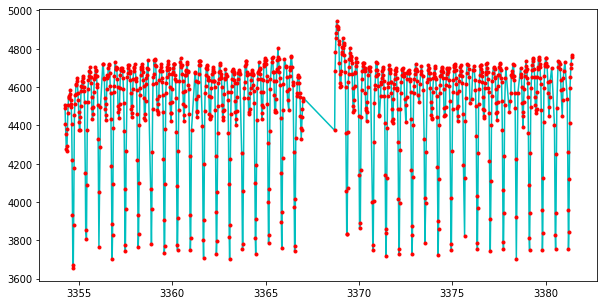

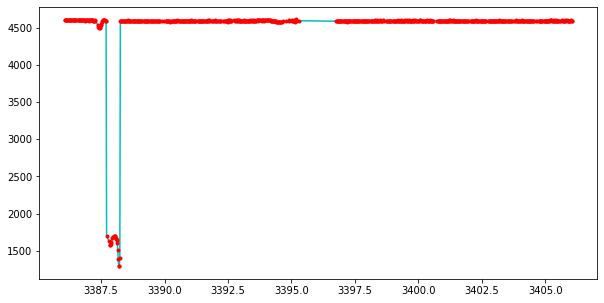

In [18]:
see_period('/Users/laote/sdsu/Research/binary/curve_bin/1600K_Curve_binary/tic00349157974_SEC002_LC.txt')
see_period('/Users/laote/sdsu/Research/binary/curve_bin/1600K_Curve_binary/tic00349157974_SEC003_LC.txt')

In [17]:
# Algol 

In [1]:
# tic00149503323 0.1 phase for second ecilpse
# tic00349905506 0.15 phase for second ecilpse
# tic00260132330 0.15 phase for dim second ecilpse
# tic00350183081 0.15 phase for second ecilpse
# tic00255619508 0.2 phase for second ecilpse
# tic00167089522 0.2 phase for second ecilpse
# tic00167251735 0.2 phase for second ecilpse
# tic00238202532 0.2 phase for second ecilpse
# tic00255619508 0.2 phase for second ecilpse (interesting)
# tic00278826996 0.2 phase for second ecilpse
# tic00307084982 0.2 phase for second ecilpse
# tic00176980477 0.25 phase for second ecilpse
# tic00278990501 0.25 phase for second ecilpse
# tic00302599843 0.25 phase for second ecilpse

# tic00167201539 dim second ecilpse
# tic00219406758 dim second ecilpse
# tic00255641111 dim second ecilpse
# tic00259701724 dim second ecilpse

# tic00177118177 wide ecilpse
# tic00179317684 wide ecilpse
# tic00219177716 wide ecilpse
# tic00220430912 wide ecilpse
# tic00232025523 wide ecilpse
# tic00260608573 wide ecilpse
# tic00262576400 very wide ecilpse
# tic00276790966 wide ecilpse
# tic00294206429 wide ecilpse
# tic00300012172 wide ecilpse
# tic00340058770 wide ecilpse
# tic00349156417 wide ecilpse
# tic00350954272 wide ecilpse
# tic00382245443 wide ecilpse

# tic00041088200 close with other binary
# tic00349311164 third body? clear light curve

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


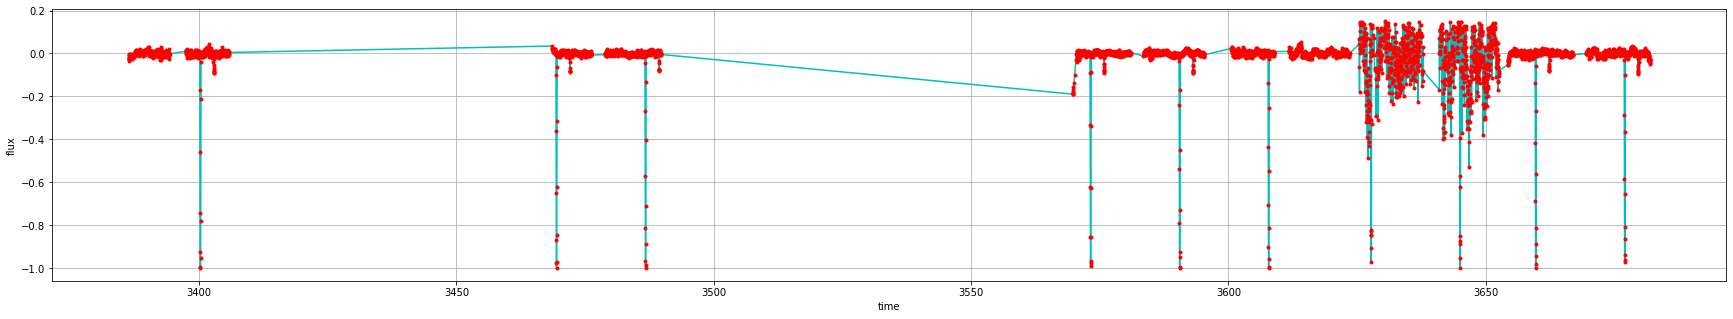

In [69]:
a,b,c = mulit_light_curve('/Users/laote/sdsu/Research/binary/curve_bin/1600K_Curve_binary/tic00260132330_SEC001_LC.txt',look=True)

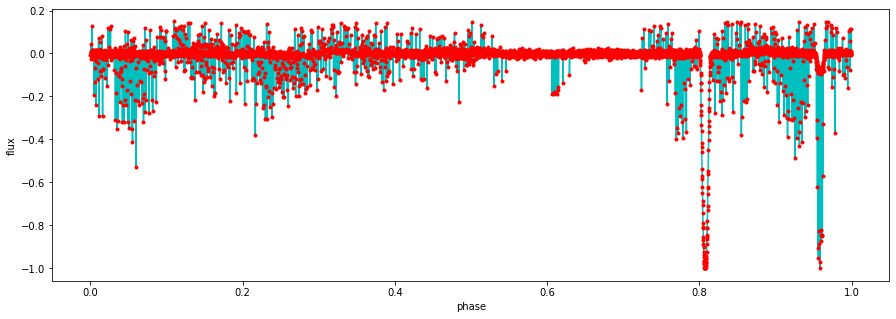

(3.062046016754395, array([0.00000000e+00, 1.77003394e-04, 2.91777411e-04, ...,
        9.99607116e-01, 9.99796317e-01, 9.99861032e-01]), array([-0.00647862, -0.00433066,  0.00742686, ..., -0.0010214 ,
         0.11322743,  0.00733046]))

In [70]:
sing_dc_func(17.2987809,a,b,c,look=True)

In [41]:
1.8982845*3

5.6948535